# Visualization
I want to visualize the PPI network. In this notebook, I'll try to:
* visualize the whole network (4800 nodes approximately)
* Mark differentially expressed genes (or adjust node size depending on p-value or log2foldchange)
* mark pagerank of genes or any other network property

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import h5py
from py2cytoscape import util as cy
import requests
import json
from IPython.display import Image

from collections import OrderedDict
import numpy as np
from bokeh.charts import Bar
from bokeh.plotting import *

output_notebook()

Loading BokehJS ...

In [2]:
PORT_NUMBER = 1234
IP = 'localhost'
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}
# Delete all networks in current session
requests.delete(BASE + 'session')

<Response [200]>

## Load PPI network & convert to networkx Graph

In [64]:
# load data
fname = '../data/preprocessing/ppi_networks.h5'
with h5py.File(fname, 'r') as f:
    gene_expression_data = pd.DataFrame(f['gene_expression'][:])
    ppi_network = f['consensusPathDB_ppi'][:]
    gene_names = f['gene_names'][:]

# load pagerank results
pagerank_with_de_scores = pd.DataFrame.from_csv('../data/pagerank/pagerank_scores_with_de.tsv', sep='\t')

In [69]:
gene_names_df = pd.DataFrame(gene_names)
gene_names_df.set_index(0, inplace=True)
gene_names_df.columns = ['Name']
gene_names_with_features = pagerank_with_de_scores.join(gene_names_df)

In [86]:
gene_names_with_features.dropna().shape

(343, 13)

In [73]:
# bring to networkx
G = nx.from_numpy_matrix(ppi_network)

nx.set_node_attributes(G, 'id', dict(enumerate(list(gene_names[:, 0]))))
nx.set_node_attributes(G, 'PageRank',
                       {key:float(value) for key, value in enumerate(gene_names_with_features.Rank)}
                      )
nx.set_node_attributes(G, 'GEVar',
                       {key:float(value) for key, value in enumerate(gene_names_with_features.Gene_Expression_Variance)}
                      )
nx.set_node_attributes(G, 'PRScore',
                       {key:float(value) for key, value in enumerate(gene_names_with_features.PageRank_Score)}
                      )
nx.set_node_attributes(G, 'DEPval',
                       {key:float(value) for key, value in enumerate(gene_names_with_features.pvalue)}
                      )
nx.set_node_attributes(G, 'name', dict(enumerate(list(gene_names[:, 1]))))
nx.write_graphml(G, 'network_de.xml')

In [88]:
cyto_network = cy.from_networkx(G)
res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

KeyError: 0

In [41]:
G.

Number of Nodes = 3
Number of Edges = 4


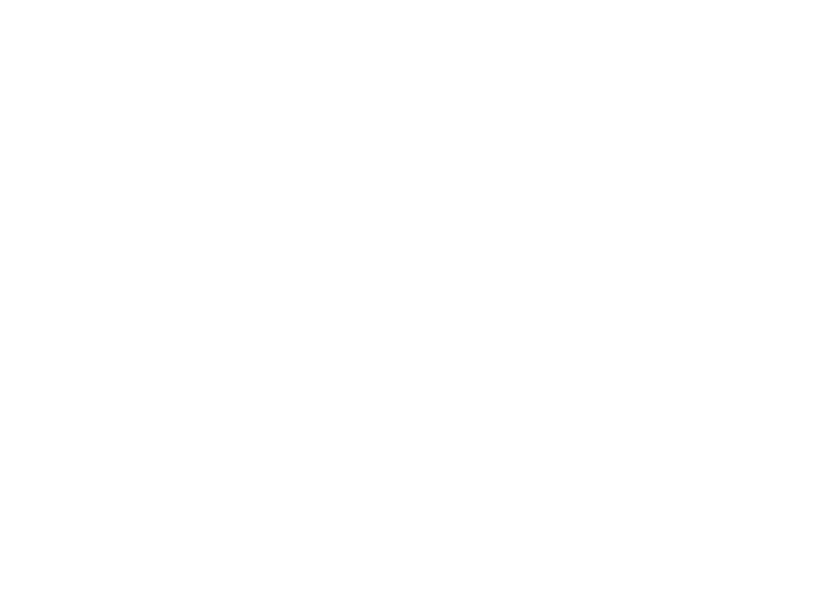

In [42]:

g = nx.MultiDiGraph()
g.add_node(1)
g.add_node(2)
g.add_node(3)

g.add_edge(1, 2)
g.add_edge(2, 1)
g.add_edge(1, 3)
g.add_edge(3, 2)

print('Number of Nodes = ' + str(g.number_of_nodes()))
print('Number of Edges = ' + str(g.number_of_edges()))

# Convert NetworkX Graph object 
cytoscape_network = cy.from_networkx(g)

res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')